# Study of the Rössler model
### and the different synchronizations it can lead to

In [74]:
import numpy as np
import recurrence as rec
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.integrate import solve_ivp

In [75]:
#Recurrence matrix with FAN
def recurrence_matrix_fan(timeseries, RR, transpose = False):
    nn_i = int(RR*len(timeseries))

    if timeseries.ndim == 1:
        r_matrix = []
        for i in range(len(timeseries)):
            current_row = []
            for j in range(len(timeseries)):
                current_value = np.abs(timeseries[i] - timeseries[j])
                current_row.append(current_value)

            current_row = np.array(current_row)
            recs_i = np.argsort(current_row)[:nn_i]
            current_row[:] = 0
            current_row[recs_i] = 1
        
            r_matrix.append(current_row)
    
        return np.array(r_matrix)
    
    else: 
        '''
        We will use euclidean distance in order to estimate neighbours.
        '''
        #Create distance matrix
        if transpose == True:
            timeseries = timeseries.T

        d_matrix = squareform(pdist(timeseries, metric = 'euclidean'))

        for i in range(d_matrix.shape[0]):
            current_row = d_matrix[i]
            recs_i = np.argsort(current_row)[:nn_i]
            current_row[:] = 0
            current_row[recs_i] = 1

            d_matrix[i] = current_row   

        return d_matrix 

# Generalized synchronization

To illustrate the application of JPR, we analyse an interaction of two rather different chaotic oscillators, the Lorenz
system (Eqs. (A.12) with ' = 10, r = 28 and b = 83
) driven by a Rössler system (Eqs. (A.11) with a = 0.45, b = 2 and
c = 4). Since the driven Lorenz system is asymptotically stable [152], systems (A.11) and (A.12) are in GS. However,
the shapes of both attractors in phase space are very different (Fig. 39A and B), and both are neither in LS nor in CS
(Fig. 39C).
To mimic typical experimental situations, we perform the analysis with just one component of each system. 10,000
data points are used with a sampling time interval of 0.02. Using x3 and y3 as observables, we reconstruct the phase
space vectors using delay coordinates, Eq. (9), for ⃗x: m = 3, ) = 85 and for ⃗y: m = 3, ) = 10.

In [76]:
#Lorenz system driven by a Roessler system
#taken from Marwan (2007), eqs. A.11 and A.12
def RdL(t, X, a, b, c, sigma, r, b2):
    """
    X is a flattened vector [x1, x2, x3, y1, y2, y3].
    x corresponds to the Roessler system, y corresponds to the 
    Roessler driven Lorenz system 
    """
    dX = np.zeros(len(X))

    #Roessler system (A.11)
    dX[0] = b + X[0]*(X[1] - c)
    dX[1] = -X[0] - X[2]
    dX[2] = X[1] + a*X[2]

    #Lorenz system (A.12)
    u = np.sum(X[:3])

    dX[3] = -sigma*(X[3] - X[4])
    dX[4] = r*u - X[4] - u*X[5]
    dX[5] = u*X[4] - b2*X[5]

    return dX

In [77]:
# Parametres For The Simulation

sigma = 10  
a, b, c = 0.45, 2, 4
r = 28
b2 = 8/3 
epsilon = 0.01  
T = 10000*0.02  
dt = 0.02

In [78]:
# Numerically Integrate The System States

np.random.seed(42)
X0 = [0,0,0,0,0,0]

t_span = (0, T)
t_eval = np.arange(0, T, dt)

sol = solve_ivp(RdL, t_span, X0, t_eval=t_eval, args=(a, b, c, sigma, r, b2), method="RK45")

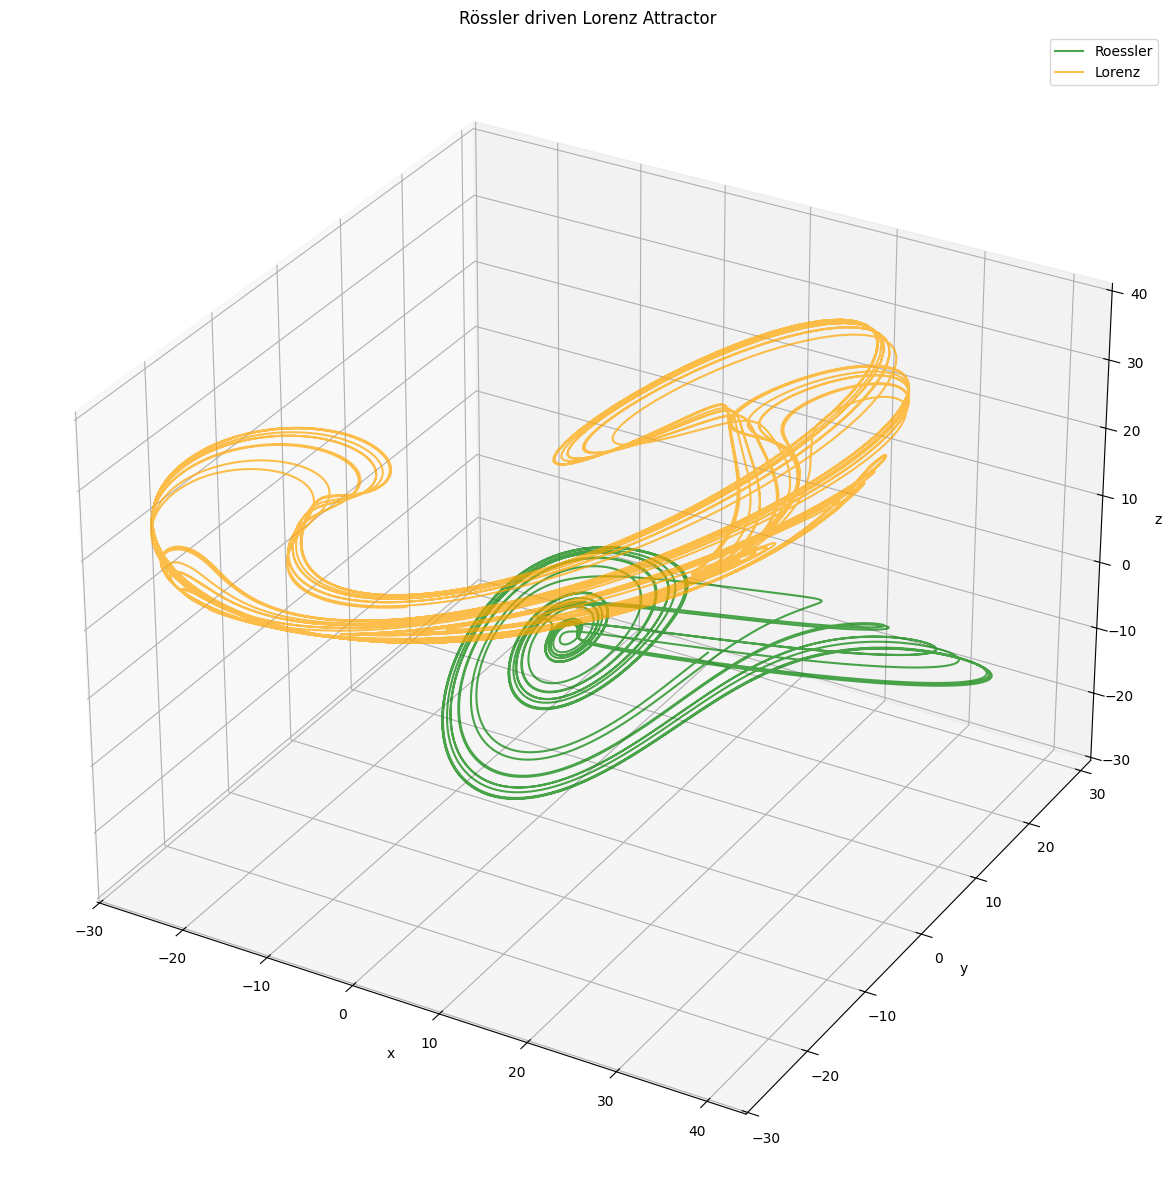

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.plot(5*sol.y[0], 5*sol.y[1], 5*sol.y[2], alpha=0.7, label = 'Roessler', color = 'green')
ax.plot(sol.y[3], sol.y[4], sol.y[5], alpha=0.7, label = 'Lorenz', color = 'orange')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"Rössler driven Lorenz Attractor")

plt.show()

In [80]:
#Separate models
R_ts = sol.y[:3]
L_ts = sol.y[3:]

In [81]:
#Compute RM
rec_R = recurrence_matrix_fan(R_ts.T,0.06)
rec_L = recurrence_matrix_fan(L_ts.T,0.06)

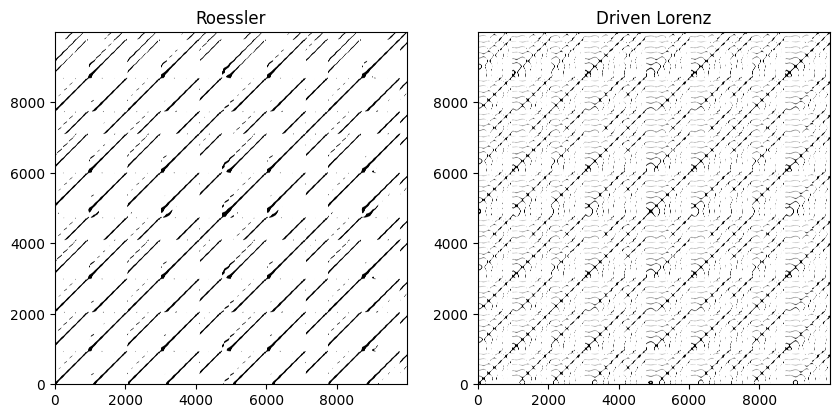

In [82]:
#Visualize
fig, axs = plt.subplots(1,2,figsize=(10, 10))

#Plot
axs[0].imshow(rec_R, origin='lower', cmap = 'binary')
axs[0].set_title('Roessler')

axs[1].imshow(rec_L, origin='lower', cmap = 'binary')
axs[1].set_title('Driven Lorenz')


plt.show()

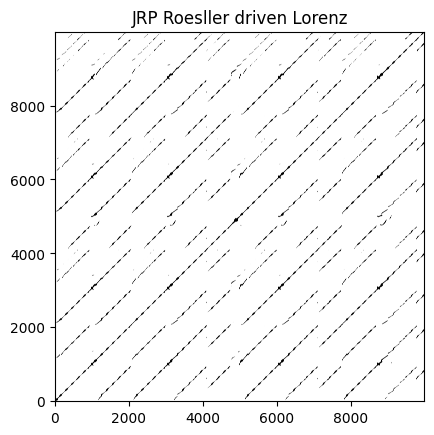

In [83]:
#Visualize
fig, axs = plt.subplots()

#Plot
axs.imshow(rec_R*rec_L, origin='lower', cmap = 'binary')
axs.set_title("JRP Roesller driven Lorenz")


plt.show()

Let's take a look at $S(\tau)$.

In [84]:
lagged_ts_L = [L_ts.T[i : len(L_ts.T) - 100 + i] for i in range(100)]

In [89]:
rec_R = recurrence_matrix_fan(R_ts.T[:len(R_ts.T) - 100],0.06)

In [90]:
s_tau = []


for i in range(100):
    actual_L = lagged_ts_L[i]

    rec_L = recurrence_matrix_fan(actual_L,0.06)

    jrp = rec_R*rec_L

    N = len(actual_L)


    s_tau.append((np.sum(jrp)/(N**2))/0.06)

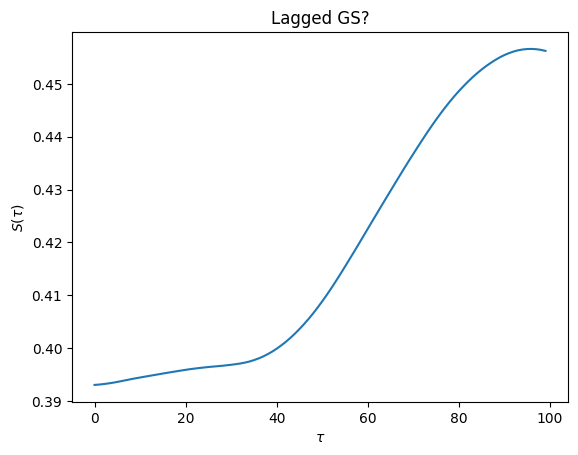

In [91]:
fig, ax = plt.subplots()             
ax.plot(np.arange(0,len(s_tau),1), s_tau)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$S(\tau)$')
ax.set_title('Lagged GS?')

plt.show() 